# Generating Images to Fool an MNIST Classifier

_This tutorial is part of the series of pyribs tutorials! See [here](https://docs.pyribs.org/en/latest/tutorials.html) for the list of all tutorials and the order in which they should be read._

Despite their high performance on classification tasks such as MNIST, neural networks like the [LeNet-5](https://en.wikipedia.org/wiki/LeNet) have a weakness: they are easy to fool. Namely, given images like the ones below, a classifier may confidently believe that it is seeing certain digits, even though the images look like random noise to humans. Naturally, this phenomenon raises some concerns, especially when the network in question is used in a safety-critical system like a self-driving car. Given such unrecognizable input, one would hope that the network at least has low confidence in its prediction.

![fooling images example](_static/fooling_mnist_example.png)

To make matters worse for neural networks, generating such images is incredibly easy with QD algorithms. As shown in [Nguyen 2015](http://anhnguyen.me/project/fooling/), one can use simple MAP-Elites to generate these images. In this tutorial, we will use the pyribs version of MAP-Elites to do just that.

## Setup

First, we install pyribs and PyTorch.

In [ ]:
%pip install ribs torch

Here, we import PyTorch and some utilities.

In [ ]:
import time
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm, trange

Below, we check what device is available for PyTorch. On Colab, activate the GPU by clicking "Runtime" in the toolbar at the top. Then, click "Change Runtime Type", and select "GPU".

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Preliminary: MNIST Network

We have pretrained a high-performing [LeNet-5](https://en.wikipedia.org/wiki/LeNet) classifier (98.4% training set accuracy, 98.5% test set accuracy) for the MNIST dataset using the code [here](https://github.com/icaros-usc/pyribs/tree/master/tutorials/mnist/train_mnist_classifier.py). This is the same network that we use in the [LSI MNIST](https://docs.pyribs.org/en/stable/tutorials/lsi_mnist.html) tutorial. Below, we define the network.

In [3]:
LENET5 = nn.Sequential(
    nn.Conv2d(1, 6, (5, 5), stride=1, padding=0),  # (1,28,28) -> (6,24,24)
    nn.MaxPool2d(2),  # (6,24,24) -> (6,12,12)
    nn.ReLU(),
    nn.Conv2d(6, 16, (5, 5), stride=1, padding=0),  # (6,12,12) -> (16,8,8)
    nn.MaxPool2d(2),  # (16,8,8) -> (16,4,4)
    nn.ReLU(),
    nn.Flatten(),  # (16,4,4) -> (256,)
    nn.Linear(256, 120),  # (256,) -> (120,)
    nn.ReLU(),
    nn.Linear(120, 84),  # (120,) -> (84,)
    nn.ReLU(),
    nn.Linear(84, 10),  # (84,) -> (10,)
    nn.LogSoftmax(dim=1),  # (10,) log probabilities
).to(device)
LENET5_MEAN_TRANSFORM = 0.1307
LENET5_STD_DEV_TRANSFORM = 0.3081

Now, we download the weights and load them into the network.

In [4]:
import os
from urllib.request import urlretrieve
from pathlib import Path

LOCAL_DIR = Path("fooling_mnist_weights")
LOCAL_DIR.mkdir(exist_ok=True)
WEB_DIR = "https://raw.githubusercontent.com/icaros-usc/pyribs/master/tutorials/mnist/"

# Download the model file to LOCAL_DIR.
filename = "mnist_classifier.pth"
model_path = LOCAL_DIR / filename
if not model_path.is_file():
    urlretrieve(WEB_DIR + filename, str(model_path))

# Load the weights of the network.
state_dict = torch.load(
    str(LOCAL_DIR / "mnist_classifier.pth"),
    map_location=device,
)

# Insert the weights into the network.
LENET5.load_state_dict(state_dict)

<All keys matched successfully>

## Fooling the Classifier with MAP-Elites

In order to fool the classifier into seeing various digits, we use MAP-Elites. As we have 10 distinct digits (0-9), we have a discrete measure space with 10 values. Note that while pyribs is designed for continuous search spaces, the measure space can be either continuous or discrete.

Our classifier outputs a log probability vector with its belief that it is seeing each digit. Thus, our objective for each digit is to maximize the probability that the classifier assigns to the image associated with it. For instance, for digit 5, we want to generate an image that makes the classifier believe with high probability that it is seeing a 5.

In pyribs, we implement MAP-Elites with a [`GridArchive`](https://docs.pyribs.org/en/latest/api/ribs.archives.GridArchive.html) and a [`GaussianEmitter`](https://docs.pyribs.org/en/latest/api/ribs.emitters.GaussianEmitter.html). Below, we start by constructing the `GridArchive`. The archive has 10 cells and a range of (0,10). Since `GridArchive` was originally designed for continuous spaces, it does not directly support discrete spaces, but by using these settings, we have a cell for each digit from 0 to 9.

In [5]:
from ribs.archives import GridArchive
img_size = (28, 28)
flat_img_size = 784  # 28 * 28

archive = GridArchive(solution_dim=flat_img_size, dims=[10], ranges=[(0, 10)])

Next, we use a single `GaussianEmitter` with batch size of 30. The emitter begins with an image filled with 0.5 (i.e. grey, since pixels are in the range $[0,1]$) and has $\sigma = 0.5$.

In [6]:
from ribs.emitters import GaussianEmitter

emitters = [
    GaussianEmitter(
        archive,
        sigma=0.5,
        # Start with a grey image.
        x0=np.full(flat_img_size, 0.5),
        # Bound the generated images to the pixel range.
        bounds=[(0, 1)] * flat_img_size,
        batch_size=30,
    )
]

Finally, we construct the scheduler to connect the archive and emitter together.

In [7]:
from ribs.schedulers import Scheduler

scheduler = Scheduler(archive, emitters)

With the components created, we now generate the images. As we use 1 emitter with batch size of 30 and run 30,000 iterations, we evaluate 900,000 images in total.

In [8]:
total_itrs = 30_000
start_time = time.time()

for itr in trange(1, total_itrs + 1, file=sys.stdout, desc='Iterations'):
    sols = scheduler.ask()

    with torch.no_grad():
        # Reshape and normalize the image and pass it through the network.
        imgs = sols.reshape((-1, 1, *img_size))
        imgs = (imgs - LENET5_MEAN_TRANSFORM) / LENET5_STD_DEV_TRANSFORM
        imgs = torch.tensor(imgs, dtype=torch.float32, device=device)
        output = LENET5(imgs)

        # The measures is the digit that the network believes it is seeing,
        # i.e. the digit with the maximum probability. The objective is the
        # probability associated with that digit.
        scores, predicted = torch.max(output.to("cpu"), 1)
        scores = torch.exp(scores)
        objs = scores.numpy()
        meas = predicted.numpy()[:,None]

    scheduler.tell(objs, meas)

Iterations: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 30000/30000 [00:55<00:00, 539.24it/s]


Below, we display the images found. Interestingly, though the images look mostly like noise, we can occasionally make out traces of the original digit. Note that MAP-Elites may not find images for all the digits, and this is mostly due to the small behavior space. Usually, QD algorithms run with fairly large behavior spaces. This is something to keep in mind when tuning QD algorithms.

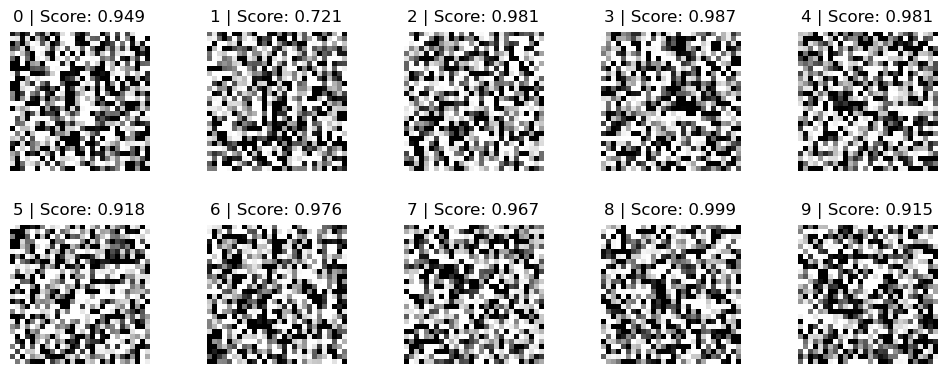

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(10, 4))
fig.tight_layout()
ax = ax.flatten()
found = set()

# Display images.
for elite in archive:
    digit = elite.index
    found.add(digit)

    # No need to normalize image because we want to see the original.
    ax[digit].imshow(elite.solution.reshape(28, 28), cmap="Greys")
    ax[digit].set_axis_off()
    ax[digit].set_title(f"{digit} | Score: {elite.objective:.3f}", pad=8)

# Mark digits that we did not generate images for.
for digit in range(10):
    if digit not in found:
        ax[digit].set_title(f"{digit} | (no solution)", pad=8)
        ax[digit].set_axis_off()

## Conclusion

In this tutorial, we used MAP-Elites to generate images that fool a LeNet-5 MNIST classifier. For further exploration, we recommend referring to [Nguyen 2015](http://anhnguyen.me/project/fooling/) and replicating or extending the other experiments described in the paper.

## Citation

If you find this tutorial useful, please cite it as:

```text
@article{pyribs_fooling_mnist,
  title   = {Generating Images to Fool an MNIST Classifier},
  author  = {Bryon Tjanaka and Matthew C. Fontaine and Stefanos Nikolaidis},
  journal = {pyribs.org},
  year    = {2021},
  url     = {https://docs.pyribs.org/en/stable/tutorials/fooling_mnist.html}
}
```